<center><img src="https://media-exp1.licdn.com/dms/image/C4E22AQEbIXZiRVkJPQ/feedshare-shrink_2048_1536/0?e=1591228800&v=beta&t=4uXLGuPLZdw16VZmiqkPdu57s6oSUWT-advRTvwzp5Q" width="1000"></center>

# SDC Certified Program in Python for Data Science

## Evaluación nivel avanzado

**Materiales para utilizar:** Está permitido el uso de apuntes. Debe usar Python para resolver los ejercicios planteados (incluir el código y programas usados para resolver las preguntas).<br>
**Formato:** el archivo notebook de Jupyter y el pdf debe ser guardado con su apellido paterno y materno sin espacios.<br>
**Asunto:**  Examen_Avanzado_ApellidoPaterno_ApellidoMaterno_Nombres<br>
**Puntaje:** Total: 20 puntos<br>

Link de la data: https://www.dropbox.com/sh/3s7j40jia09t09b/AABifaGQHpQHw4mM55tW9gpja?dl=0

## Información del conjunto de datos

Hay una falta de conjuntos de datos públicos disponibles sobre servicios financieros y especialmente en el dominio emergente de transacciones de dinero móvil. Los conjuntos de datos financieros son importantes para muchos investigadores y, en particular, para nosotros que realizamos investigaciones en el ámbito de la detección de fraudes. Parte del problema es la naturaleza intrínsecamente privada de las transacciones financieras, que no lleva a conjuntos de datos disponibles públicamente.

Presentamos un conjunto de datos sintéticos generado utilizando el simulador llamado PaySim como un enfoque para tal problema. PaySim utiliza datos agregados del conjunto de datos privado para generar un conjunto de datos sintético que se asemeja al funcionamiento normal de las transacciones e inyecta un comportamiento malicioso para luego evaluar el rendimiento de los métodos de detección de fraude.

## Información de los atributos:

Variables de entrada :

1. steep(tipo) - EFECTIVO, EFECTIVO, DÉBITO, PAGO y TRANSFERENCIA.

2. amount(cantidad) -monto de la transacción en moneda local.

3. nameOrig: cliente que inició la transacción

4. oldbalanceOrg - saldo inicial antes de la transacción

5. newbalanceOrig - nuevo saldo después de la transacción

6. nameDest - cliente que es el destinatario de la transacción

7. oldbalanceDest: destinatario del saldo inicial antes de la transacción. Tenga en cuenta que no hay información para los clientes que comienzan con M (Comerciantes).

8. newbalanceDest: nuevo destinatario del saldo después de la transacción. Tenga en cuenta que no hay información para los clientes que comienzan con M (Comerciantes).


9. isFlaggedFraud: el modelo de negocio tiene como objetivo controlar transferencias masivas de una cuenta a otra y señala intentos ilegales. Un intento ilegal en este conjunto de datos es un intento de transferir más de 200,000 en una sola transacción.

Variable de salida:

10. isFraud: son las transacciones realizadas por los agentes fraudulentos dentro de la simulación. En este conjunto de datos específico, el comportamiento fraudulento de los agentes apunta a obtener ganancias tomando el control de las cuentas de los clientes e intentando vaciar los fondos transfiriéndolos a otra cuenta y luego retirando del sistema.


#### **0. Pasos previos.**

##### Importando librerías necesarias

In [1]:
import os

import h2o
import matplotlib.pyplot as plt
import model_evaluation_utils as meu
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels as sm
from graphviz import Source
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from imblearn.under_sampling import NearMiss
from joblib import dump
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz

##### Establecer directorio de trabajo

In [2]:
os.chdir("./Data")

##### Leer el archivo de trabajo

In [3]:
bank = pd.read_csv("PS_20174392719_1491204439457_log.csv")
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


##### Comprobar el porcentaje de valores nulos en el dataframe

In [4]:
bank.isnull().sum() * 100 / len(bank)

step              0.0
type              0.0
amount            0.0
nameOrig          0.0
oldbalanceOrg     0.0
newbalanceOrig    0.0
nameDest          0.0
oldbalanceDest    0.0
newbalanceDest    0.0
isFraud           0.0
isFlaggedFraud    0.0
dtype: float64

In [5]:
bank.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


#### **1.	Dividir los datos para el entrenamiento y testeo en una proporción de 70 y 30, respectivamente.**

##### Seleccionando columnas a trabajar

In [6]:
predictores = [
    "amount",
    "oldbalanceOrg",
    "newbalanceOrig",
    "oldbalanceDest",
    "newbalanceDest",
]
target = ["isFraud"]

##### Particionamiento de la data

In [7]:
x = bank[predictores].values
y = bank[target].values

##### Generamos la data de entrenamiento y testeo

In [8]:
xtrain, xtest, ytrain, ytest = train_test_split(
    x, y, train_size=0.7, stratify=y, random_state=2020
)

#### **2.	Aplicar balanceo de datos under-sampling, fijando como parámetro 0.8.**

##### Verificando la frecuencia

In [9]:
Class_freq = pd.value_counts(bank["isFraud"], sort=True)
Class_freq

0    6354407
1       8213
Name: isFraud, dtype: int64

##### Verificando el porcentaje

In [10]:
Class_freq * 100 / Class_freq.sum()

0    99.870918
1     0.129082
Name: isFraud, dtype: float64

##### Graficando la data resultante

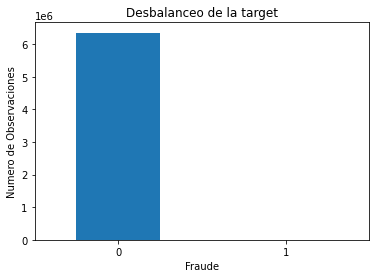

In [11]:
Class_freq.plot(kind="bar", rot=0)
plt.title("Desbalanceo de la target")
plt.xlabel("Fraude")
plt.ylabel("Numero de Observaciones")
plt.show()

##### Instanciar un objeto de clase NearMiss

In [12]:
unds = NearMiss(sampling_strategy=0.8, n_neighbors=11)

##### Balanceando los datos de entrenamiento

In [13]:
xtrain_us, ytrain_us = unds.fit_resample(xtrain, ytrain)

In [14]:
df_xtrain_us = pd.DataFrame(xtrain_us,columns=predictores)
df_ytrain_us = pd.DataFrame(ytrain_us,columns=target)
bank_unds_train = pd.concat([df_xtrain_us, df_ytrain_us], axis = 1)
bank_unds_train.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,21673.23,21685.00,11.77,0.0,0.0,0
1,21628.87,21614.00,0.00,0.0,0.0,0
2,21792.13,21751.75,0.00,0.0,0.0,0
3,162.17,168.00,5.83,0.0,0.0,0
4,176.50,164.00,0.00,0.0,0.0,0


##### Verificando la frecuencia

In [15]:
count_classes = pd.value_counts(bank_unds_train["isFraud"], sort=True)
count_classes

0    7186
1    5749
Name: isFraud, dtype: int64

##### Graficando la data resultante

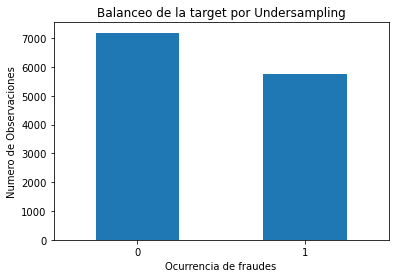

In [16]:
count_classes.plot(kind="bar", rot=0)
plt.title("Balanceo de la target por Undersampling")
plt.xlabel("Ocurrencia de fraudes")
plt.ylabel("Numero de Observaciones")
plt.show()

#### **3. Implementar el modelo de árboles de decisión a los datos de entrenamiento.**

##### Instanciando una clase DecisionTreeClassifier

In [17]:
arboles = []
for i in range(2,10):
    arbol = {}
    treecko = DecisionTreeClassifier(criterion="entropy", min_samples_split=20, max_depth=i, random_state=2020)
    treecko.fit(xtrain_us, ytrain_us)
    arbol['Profundidad'] = i
    arbol['Precision entrenamiento'] = metrics.precision_score(ytrain_us, treecko.predict(xtrain_us))
    arbol['Precision prueba'] = metrics.precision_score(ytest, treecko.predict(xtest))
    arboles.append(arbol)
dataframe = pd.DataFrame(data = arboles)
dataframe.head(10)

,Profundidad,Precision entrenamiento,Precision prueba
0,2,0.991189,0.001296
1,3,1.000000,0.001492
2,4,1.000000,0.001460
3,5,1.000000,0.001460
4,6,1.000000,0.001460
5,7,0.999303,0.001462
6,8,0.999130,0.001463
7,9,0.999130,0.001463


In [18]:
tree = DecisionTreeClassifier(criterion="entropy", min_samples_split=20, max_depth=3, random_state=2020)

##### Validación cruzada

In [19]:
score_precision = cross_val_score(
    estimator=tree, X=xtrain_us, y=ytrain_us, scoring="precision", cv=10
)

In [20]:
score_precision

array([0.94262295, 1.        , 1.        , 1.        , 1.        ,
       0.99823944, 1.        , 0.99825784, 0.94859038, 0.99824869])

##### Gráfico de convergencia

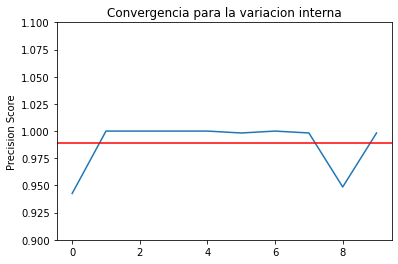

In [21]:
plt.plot(range(0, 10), score_precision)
plt.ylim([0.9, 1.1])
plt.axhline(y=score_precision.mean(), color="red")
plt.title("Convergencia para la variacion interna")
plt.ylabel("Precision Score")
plt.show()

##### Validación cruzada

In [22]:
score_accuracy = cross_val_score(
    estimator=tree, X=xtrain_us, y=ytrain_us, scoring="accuracy", cv=10
)

In [23]:
score_accuracy

array([0.97295209, 0.99613601, 0.99690881, 0.99536321, 0.99690881,
       0.99381284, 0.99845321, 0.99767981, 0.97370456, 0.99535963])

##### Gráfico de convergencia

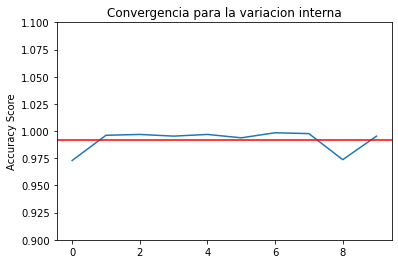

In [24]:
plt.plot(range(0, 10), score_accuracy)
plt.ylim([0.9, 1.1])
plt.axhline(y=score_accuracy.mean(), color="red")
plt.title("Convergencia para la variacion interna")
plt.ylabel("Accuracy Score")
plt.show()

##### Entrenar el modelo

In [25]:
tree.fit(xtrain_us, ytrain_us)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=20,
                       random_state=2020)

##### Graficando el árbol

In [26]:
with open("bupa_dtree.dot", "w") as dotfile:
    export_graphviz(tree, out_file=dotfile, feature_names=predictores)
    dotfile.close()

In [27]:
file = open("bupa_dtree.dot", "r")
text = file.read()

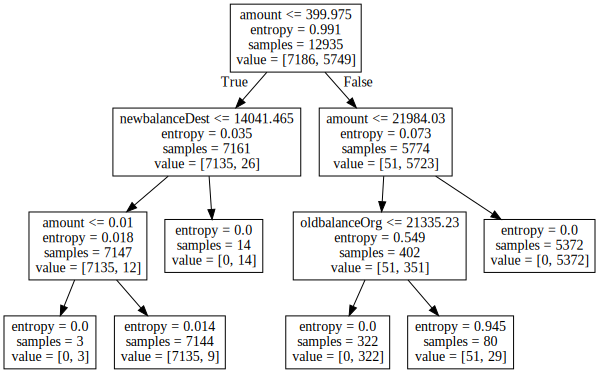

In [28]:
Source(text)

##### Ver las características importantes del modelo de árboles de decisión

In [29]:
features = pd.DataFrame({"nombres": predictores, "valores": tree.feature_importances_})

In [30]:
features.sort_values("valores", ascending=False)

,nombres,valores
0,amount,0.979018
1,oldbalanceOrg,0.011470
4,newbalanceDest,0.009512
2,newbalanceOrig,0.000000
3,oldbalanceDest,0.000000


In [31]:
importancia_var = features[features.valores != 0]

In [32]:
y_posicion = list(range(len(importancia_var)))

In [33]:
scores_model = tuple(importancia_var["valores"].values)

In [34]:
names_model = tuple(importancia_var["nombres"].values)

##### Graficar las características importantes del modelo de árboles de decisión

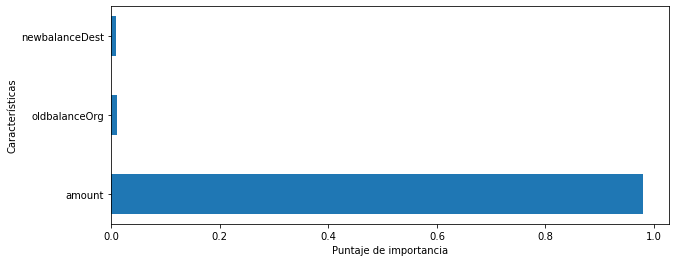

In [35]:
plt.figure(figsize=(10, 4))
plt.barh(y_posicion, scores_model, height=0.5, align="center")
plt.yticks(y_posicion, names_model)
plt.xlabel("Puntaje de importancia")
plt.ylabel("Características")
plt.show()

#### **4. Implementar el modelo de random forest a los datos de entrenamiento.**

In [36]:
rf=RandomForestClassifier(n_estimators=100,criterion='entropy', max_depth=3,random_state=2020)

In [37]:
rf.fit(xtrain_us,ytrain_us)

RandomForestClassifier(criterion='entropy', max_depth=3, random_state=2020)

#### **5.  Implementar el modelo de naive bayes a los datos de entrenamiento.**

In [38]:
nbayes=GaussianNB()

In [39]:
nbayes.fit(xtrain_us,ytrain_us)

GaussianNB()

#### **6. Implementar el modelo de redes neuronales a los datos de entrenamiento.**

In [40]:
neuronal=MLPClassifier(random_state=2020)

In [41]:
neuronal.fit(xtrain_us,ytrain_us)

MLPClassifier(random_state=2020)

#### **7. Haciendo uso de las métricas de accuracy, sensibilidad. especificidad, auc y curva ROC evaluar los modelos generados (train y test) y realizar un análisis.**

In [42]:
def prediccion(model, data):
    prob_df = model.predict_proba(data)
    dataframe = pd.DataFrame(prob_df[:, 1], columns=["prob y=1"])
    dataframe["prediccion"] = np.where(dataframe["prob y=1"] > 0.5, 1, 0)
    return dataframe

In [43]:
class metricas:
    def __init__(self, true_label, predict_label, model, model_type):
        self.TN, self.FP, self.FN, self.TP = metrics.confusion_matrix(
            true_label, predict_label
        ).ravel()
        (self.fpr, self.tpr, a) = roc_curve(true_label, predict_label)
        print(type(self.fpr), type(self.tpr))
        self.auc_metric = auc(self.fpr, self.tpr)
        self.model = model
        self.model_type = model_type

    def accuracy(self):
        return (self.TP + self.TN) / (self.TP + self.TN + self.FN + self.FP)

    def auc(self):
        return self.auc_metric

    def sensibility(self):
        return (self.TP) / (self.TP + self.FN)

    def specificity(self):
        return (self.TN) / (self.TN + self.FP)

    def roc_curve(self):
        plt.figure(figsize=(5, 5), dpi=100)
        plt.plot(
            self.fpr,
            self.tpr,
            linestyle="-",
            label=self.model + "(auc=%0.3f)" % self.auc_metric,
        )
        plt.title("Curva ROC para data " + self.model_type)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()

        x = [i * 0.01 for i in range(100)]
        y = [i * 0.01 for i in range(100)]
        plt.plot(x, y)
        plt.show()

##### **7.1 Árboles de decisión**

###### **METRICAS DE DATA DE ENTRENAMIENTO**

In [44]:
prob_df_train_tree = prediccion(tree, xtrain_us)
prob_df_train_tree.head()

,prob y=1,prediccion
0,0.36250,0
1,0.36250,0
2,0.36250,0
3,0.00126,0
4,0.00126,0


In [45]:
meu.display_classification_report(ytrain_us, prob_df_train_tree["prediccion"])

              precision    recall  f1-score   support

           1       1.00      0.99      1.00      5749
           0       0.99      1.00      1.00      7186

    accuracy                           1.00     12935
   macro avg       1.00      1.00      1.00     12935
weighted avg       1.00      1.00      1.00     12935



In [46]:
pd.value_counts(prob_df_train_tree.prediccion)

0    7224
1    5711
Name: prediccion, dtype: int64

In [47]:
tree_class_train = metricas(ytrain_us, prob_df_train_tree["prediccion"], "tree", "entrenamiento")

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


Accuracy

In [48]:
accuracy_train_tree = tree_class_train.accuracy().round(3)
print("El Accuracy para la Data de Entrenamiento es:", accuracy_train_tree)

El Accuracy para la Data de Entrenamiento es: 0.997


Sensibilidad

In [49]:
sensibilidad_train_tree = tree_class_train.sensibility().round(3)
print(
    "La Sensibilidad para la Data de Entrenamiento es:", sensibilidad_train_tree
)

La Sensibilidad para la Data de Entrenamiento es: 0.993


Especificidad

In [50]:
especificidad_train_tree = tree_class_train.specificity().round(3)
print(
    "La Especificidad para la Data de Entrenamiento es:", especificidad_train_tree,
)

La Especificidad para la Data de Entrenamiento es: 1.0


AUC

In [51]:
# Para calcular de la curva ROC y AUC, la función roc_curve exige que las categorias sean 0 y 1
auc_train_tree = tree_class_train.auc().round(3)
print(
    "El area Bajo la Curva(AUC) para Data de Entrenamiento es: ",
    auc_train_tree,
)

El area Bajo la Curva(AUC) para Data de Entrenamiento es:  0.997


ROC

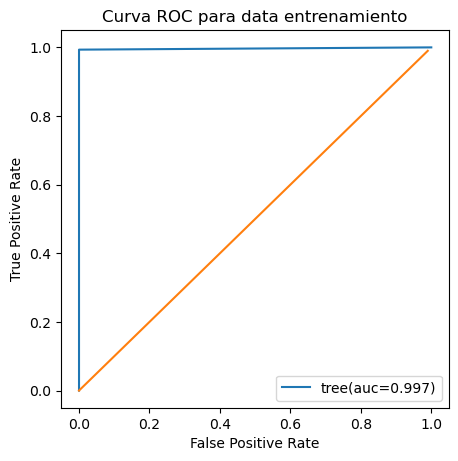

In [52]:
tree_class_train.roc_curve()

###### **METRICAS DE DATA DE TESTEO**

In [53]:
prob_df_test_tree = prediccion(tree, xtest)
prob_df_test_tree.head()

,prob y=1,prediccion
0,1.0000,1
1,1.0000,1
2,1.0000,1
3,1.0000,1
4,0.3625,0


In [54]:
meu.display_classification_report(ytest, prob_df_test_tree["prediccion"])

              precision    recall  f1-score   support

           1       0.00      0.99      0.00      2464
           0       1.00      0.14      0.25   1906322

    accuracy                           0.14   1908786
   macro avg       0.50      0.57      0.13   1908786
weighted avg       1.00      0.14      0.25   1908786



In [55]:
pd.value_counts(prob_df_test_tree.prediccion)

1    1639179
0     269607
Name: prediccion, dtype: int64

In [56]:
tree_class_test = metricas(ytest, prob_df_test_tree["prediccion"], "tree", "testeo")

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


Accuracy

In [57]:
accuracy_test_tree = tree_class_test.accuracy().round(3)
print("El Accuracy para la Data de Entrenamiento es:", accuracy_test_tree)

El Accuracy para la Data de Entrenamiento es: 0.143


Sensibilidad

In [58]:
sensibilidad_test_tree = tree_class_test.sensibility().round(3)
print(
    "La Sensibilidad para la Data de Entrenamiento es:", sensibilidad_test_tree
)

La Sensibilidad para la Data de Entrenamiento es: 0.992


Especificidad

In [59]:
especificidad_test_tree = tree_class_test.specificity().round(3)
print(
    "La Especificidad para la Data de Entrenamiento es:",
    especificidad_test_tree,
)

La Especificidad para la Data de Entrenamiento es: 0.141


AUC

In [60]:
auc_test_tree = tree_class_test.auc().round(3)
print(
    "El area Bajo la Curva(AUC) para Data de Entrenamiento es: ",
    auc_test_tree
)

El area Bajo la Curva(AUC) para Data de Entrenamiento es:  0.567


ROC

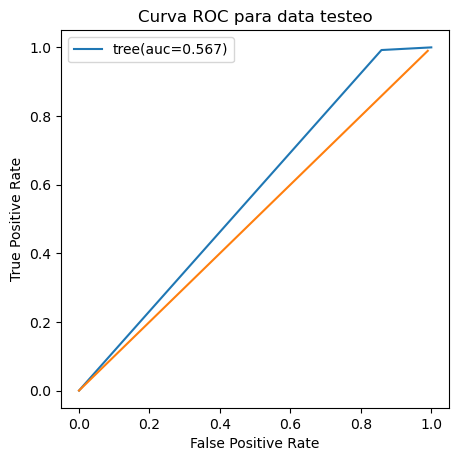

In [61]:
tree_class_test.roc_curve()

##### **7.2 Random Forest**

###### **METRICAS DE DATA DE ENTRENAMIENTO**

In [62]:
prob_df_train_rf = prediccion(rf, xtrain_us)
prob_df_train_rf.head()

,prob y=1,prediccion
0,0.497299,0
1,0.709236,1
2,0.709236,1
3,0.012416,0
4,0.012651,0


In [63]:
meu.display_classification_report(ytrain_us, prob_df_train_rf["prediccion"])

              precision    recall  f1-score   support

           1       0.99      1.00      1.00      5749
           0       1.00      1.00      1.00      7186

    accuracy                           1.00     12935
   macro avg       1.00      1.00      1.00     12935
weighted avg       1.00      1.00      1.00     12935



In [64]:
pd.value_counts(prob_df_train_rf.prediccion)

0    7164
1    5771
Name: prediccion, dtype: int64

In [65]:
rf_class_train = metricas(ytrain_us, prob_df_train_rf["prediccion"], "RandomForest", "entrenamiento")

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


Accuracy

In [66]:
accuracy_train_rf = rf_class_train.accuracy().round(3)
print("El Accuracy para la Data de Entrenamiento es:", accuracy_train_rf)

El Accuracy para la Data de Entrenamiento es: 0.996


Sensibilidad

In [67]:
sensibilidad_train_rf = rf_class_train.sensibility().round(3)
print(
    "La Sensibilidad para la Data de Entrenamiento es:", sensibilidad_train_rf
)

La Sensibilidad para la Data de Entrenamiento es: 0.998


Especificidad

In [68]:
especificidad_train_rf = rf_class_train.specificity().round(3)
print(
    "La Especificidad para la Data de Entrenamiento es:",
    especificidad_train_rf,
)

La Especificidad para la Data de Entrenamiento es: 0.995


AUC

In [69]:
# Para calcular de la curva ROC y AUC, la función roc_curve exige que las categorias sean 0 y 1
auc_train_rf = rf_class_train.auc().round(3)
print(
    "El area Bajo la Curva(AUC) para Data de Entrenamiento es: ",
    auc_train_rf,
)

El area Bajo la Curva(AUC) para Data de Entrenamiento es:  0.997


ROC

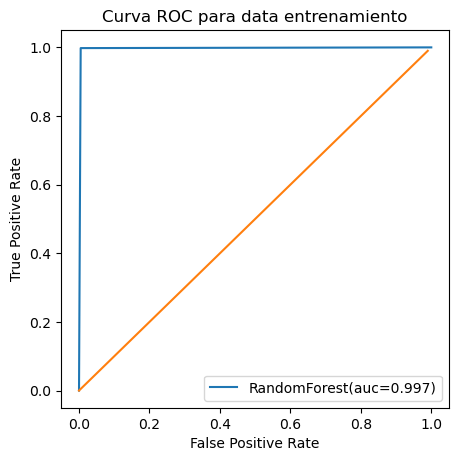

In [70]:
rf_class_train.roc_curve()

###### **METRICAS DE DATA DE TESTEO**

In [71]:
prob_df_test_rf = prediccion(rf, xtest)
prob_df_test_rf.head()

,prob y=1,prediccion
0,0.697137,1
1,0.993399,1
2,0.697137,1
3,0.697137,1
4,0.711921,1


In [72]:
meu.display_classification_report(ytest, prob_df_test_rf["prediccion"])

              precision    recall  f1-score   support

           1       0.00      1.00      0.00      2464
           0       1.00      0.11      0.20   1906322

    accuracy                           0.11   1908786
   macro avg       0.50      0.55      0.10   1908786
weighted avg       1.00      0.11      0.20   1908786



In [73]:
pd.value_counts(prob_df_test_rf.prediccion)

1    1693921
0     214865
Name: prediccion, dtype: int64

In [74]:
rf_class_test = metricas(ytest, prob_df_test_rf["prediccion"], "RandomForest", "test")

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


Accuracy

In [75]:
accuracy_test_rf = rf_class_test.accuracy().round(3)
print("El Accuracy para la Data de Entrenamiento es:", accuracy_test_rf)

El Accuracy para la Data de Entrenamiento es: 0.114


Sensibilidad

In [76]:
sensibilidad_test_rf = rf_class_test.sensibility().round(3)
print(
    "La Sensibilidad para la Data de Entrenamiento es:", sensibilidad_test_rf
)

La Sensibilidad para la Data de Entrenamiento es: 0.996


Especificidad

In [77]:
especificidad_test_rf = rf_class_test.specificity().round(3)
print(
    "La Especificidad para la Data de Entrenamiento es:",
    especificidad_test_rf,
)

La Especificidad para la Data de Entrenamiento es: 0.113


AUC

In [78]:
# Para calcular de la curva ROC y AUC, la función roc_curve exige que las categorias sean 0 y 1
auc_test_rf = rf_class_test.auc().round(3)
print(
    "El area Bajo la Curva(AUC) para Data de Entrenamiento es: ",
    auc_test_rf,
)

El area Bajo la Curva(AUC) para Data de Entrenamiento es:  0.555


ROC

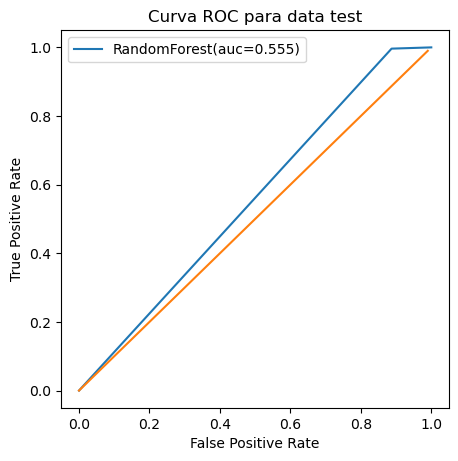

In [79]:
rf_class_test.roc_curve()

##### **7.3 Naive Bayes**

###### **METRICAS DE DATA DE ENTRENAMIENTO**

In [80]:
prob_df_train_nbayes = prediccion(nbayes, xtrain_us)
prob_df_train_nbayes.head()

,prob y=1,prediccion
0,1.000000e+00,1
1,1.000000e+00,1
2,1.000000e+00,1
3,4.799454e-21,0
4,4.794043e-21,0


In [81]:
meu.display_classification_report(ytrain_us, prob_df_train_nbayes["prediccion"])

              precision    recall  f1-score   support

           1       0.99      0.98      0.99      5749
           0       0.98      0.99      0.99      7186

    accuracy                           0.99     12935
   macro avg       0.99      0.99      0.99     12935
weighted avg       0.99      0.99      0.99     12935



In [82]:
pd.value_counts(prob_df_train_nbayes.prediccion)

0    7249
1    5686
Name: prediccion, dtype: int64

In [83]:
nbayes_class_train = metricas(ytrain_us, prob_df_train_nbayes["prediccion"], "NaiveBayes", "entrenamiento")

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


Accuracy

In [84]:
accuracy_train_nbayes = nbayes_class_train.accuracy().round(3)
print("El Accuracy para la Data de Entrenamiento es:", accuracy_train_nbayes)

El Accuracy para la Data de Entrenamiento es: 0.987


Sensibilidad

In [85]:
sensibilidad_train_nbayes = nbayes_class_train.sensibility().round(3)
print(
    "La Sensibilidad para la Data de Entrenamiento es:", sensibilidad_train_nbayes
)

La Sensibilidad para la Data de Entrenamiento es: 0.98


Especificidad

In [86]:
especificidad_train_nbayes = nbayes_class_train.specificity().round(3)
print(
    "La Especificidad para la Data de Entrenamiento es:",
    especificidad_train_nbayes,
)

La Especificidad para la Data de Entrenamiento es: 0.993


AUC

In [87]:
auc_train_nbayes = nbayes_class_train.auc().round(3)
print(
    "El area Bajo la Curva(AUC) para Data de Entrenamiento es: ",
    auc_train_nbayes,
)

El area Bajo la Curva(AUC) para Data de Entrenamiento es:  0.987


ROC

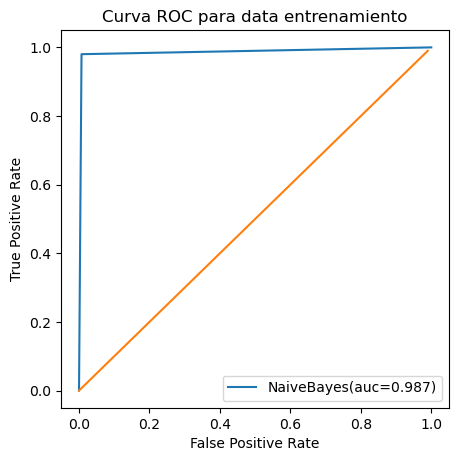

In [88]:
nbayes_class_train.roc_curve()

###### **METRICAS DE DATA DE TESTEO**

In [89]:
prob_df_test_nbayes = prediccion(nbayes, xtest)
prob_df_test_nbayes.head()

,prob y=1,prediccion
0,1.0,1
1,1.0,1
2,1.0,1
3,1.0,1
4,1.0,1


In [90]:
meu.display_classification_report(ytest, prob_df_test_nbayes["prediccion"])

              precision    recall  f1-score   support

           1       0.00      0.98      0.00      2464
           0       1.00      0.12      0.21   1906322

    accuracy                           0.12   1908786
   macro avg       0.50      0.55      0.11   1908786
weighted avg       1.00      0.12      0.21   1908786



In [91]:
pd.value_counts(prob_df_test_nbayes.prediccion)

1    1681303
0     227483
Name: prediccion, dtype: int64

In [92]:
nbayes_class_test = metricas(ytest, prob_df_test_nbayes["prediccion"], "NaiveBayes", "testeo")

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


Accuracy

In [93]:
accuracy_test_nbayes = nbayes_class_test.accuracy().round(3)
print("El Accuracy para la Data de Entrenamiento es:", accuracy_test_nbayes)

El Accuracy para la Data de Entrenamiento es: 0.12


Sensibilidad

In [94]:
sensibilidad_test_nbayes = nbayes_class_test.sensibility().round(3)
print(
    "La Sensibilidad para la Data de Entrenamiento es:", sensibilidad_test_nbayes
)

La Sensibilidad para la Data de Entrenamiento es: 0.982


Especificidad

In [95]:
especificidad_test_nbayes = nbayes_class_test.specificity().round(3)
print(
    "La Especificidad para la Data de Entrenamiento es:",
    especificidad_test_nbayes,
)

La Especificidad para la Data de Entrenamiento es: 0.119


AUC

In [96]:
# Para calcular de la curva ROC y AUC, la función roc_curve exige que las categorias sean 0 y 1
auc_test_nbayes = nbayes_class_test.auc().round(3)
print(
    "El area Bajo la Curva(AUC) para Data de Entrenamiento es: ",
    auc_test_nbayes,
)

El area Bajo la Curva(AUC) para Data de Entrenamiento es:  0.551


ROC

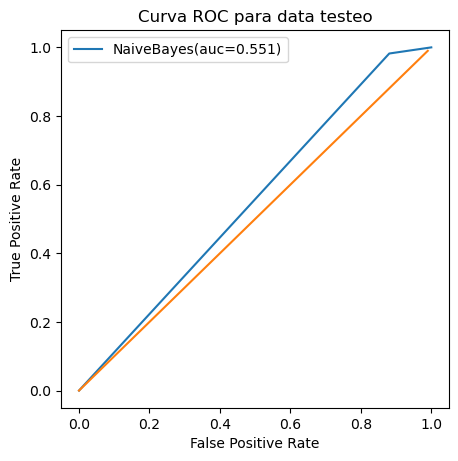

In [97]:
nbayes_class_test.roc_curve()

##### **7.4 RedesNeuronales**

###### **METRICAS DE DATA DE ENTRENAMIENTO**

In [98]:
prob_df_train_neuronal = prediccion(neuronal, xtrain_us)
prob_df_train_neuronal.head()

,prob y=1,prediccion
0,1.0,1
1,1.0,1
2,1.0,1
3,1.0,1
4,1.0,1


In [99]:
meu.display_classification_report(ytrain_us, prob_df_train_neuronal["prediccion"])

              precision    recall  f1-score   support

           1       0.89      1.00      0.94      5749
           0       1.00      0.90      0.95      7186

    accuracy                           0.94     12935
   macro avg       0.94      0.95      0.94     12935
weighted avg       0.95      0.94      0.94     12935



In [100]:
pd.value_counts(prob_df_train_neuronal.prediccion)

0    6469
1    6466
Name: prediccion, dtype: int64

In [101]:
neuronal_class_train = metricas(ytrain_us, prob_df_train_neuronal["prediccion"], "NeuralNetwork", "entrenamiento")

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


Accuracy

In [102]:
accuracy_train_neuronal = neuronal_class_train.accuracy().round(3)
print("El Accuracy para la Data de Entrenamiento es:", accuracy_train_neuronal)

El Accuracy para la Data de Entrenamiento es: 0.944


Sensibilidad

In [103]:
sensibilidad_train_neuronal = neuronal_class_train.sensibility().round(3)
print(
    "La Sensibilidad para la Data de Entrenamiento es:", sensibilidad_train_neuronal
)

La Sensibilidad para la Data de Entrenamiento es: 0.999


Especificidad

In [104]:
especificidad_train_neuronal = neuronal_class_train.specificity().round(3)
print(
    "La Especificidad para la Data de Entrenamiento es:",
    especificidad_train_neuronal,
)

La Especificidad para la Data de Entrenamiento es: 0.9


AUC

In [105]:
auc_train_neuronal = neuronal_class_train.auc().round(3)
print(
    "El area Bajo la Curva(AUC) para Data de Entrenamiento es: ",
    auc_train_neuronal,
)

El area Bajo la Curva(AUC) para Data de Entrenamiento es:  0.95


ROC

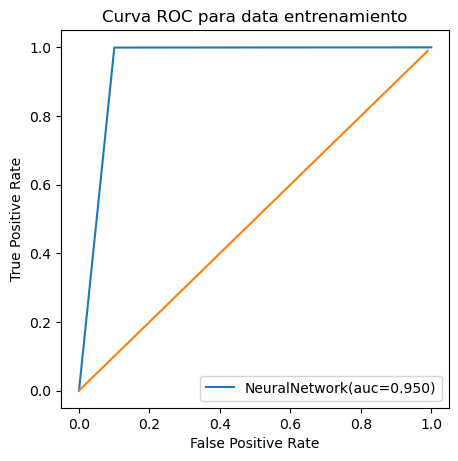

In [106]:
neuronal_class_train.roc_curve()

###### **METRICAS DE DATA DE TESTEO**

In [107]:
prob_df_test_neuronal = prediccion(neuronal, xtest)
prob_df_test_neuronal.head()

,prob y=1,prediccion
0,1.0,1
1,1.0,1
2,1.0,1
3,1.0,1
4,1.0,1


In [108]:
meu.display_classification_report(ytest, prob_df_test_neuronal["prediccion"])

              precision    recall  f1-score   support

           1       0.00      1.00      0.00      2464
           0       1.00      0.14      0.25   1906322

    accuracy                           0.14   1908786
   macro avg       0.50      0.57      0.13   1908786
weighted avg       1.00      0.14      0.25   1908786



In [109]:
pd.value_counts(prob_df_test_neuronal.prediccion)

1    1637909
0     270877
Name: prediccion, dtype: int64

In [110]:
neuronal_class_test = metricas(ytest, prob_df_test_neuronal["prediccion"], "NeuronalNetwork", "testeo")

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


Accuracy

In [111]:
accuracy_test_neuronal = neuronal_class_test.accuracy().round(3)
print("El Accuracy para la Data de Entrenamiento es:", accuracy_test_neuronal)

El Accuracy para la Data de Entrenamiento es: 0.143


Sensibilidad

In [112]:
sensibilidad_test_neuronal = neuronal_class_test.sensibility().round(3)
print(
    "La Sensibilidad para la Data de Entrenamiento es:", sensibilidad_test_neuronal
)

La Sensibilidad para la Data de Entrenamiento es: 0.999


Especificidad

In [113]:
especificidad_test_neuronal = neuronal_class_test.specificity().round(3)
print(
    "La Especificidad para la Data de Entrenamiento es:",
    especificidad_test_neuronal,
)

La Especificidad para la Data de Entrenamiento es: 0.142


AUC

In [114]:
# Para calcular de la curva ROC y AUC, la función roc_curve exige que las categorias sean 0 y 1
auc_test_neuronal = neuronal_class_test.auc().round(3)
print(
    "El area Bajo la Curva(AUC) para Data de Entrenamiento es: ",
    auc_test_neuronal,
)

El area Bajo la Curva(AUC) para Data de Entrenamiento es:  0.57


ROC

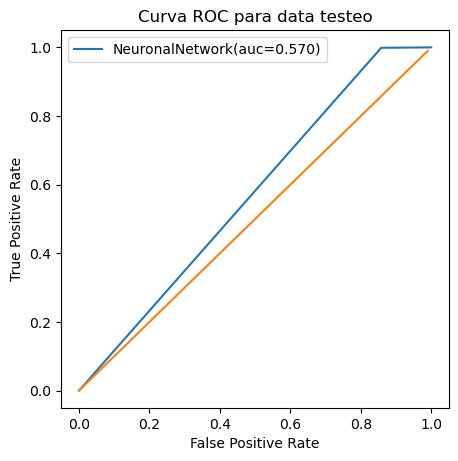

In [115]:
neuronal_class_test.roc_curve()

##### **7.5 Comparación**

Resumen de los modelos de la data de entrenamiento

In [116]:
accuracy_train = [accuracy_train_tree, accuracy_train_rf, accuracy_train_nbayes, accuracy_train_neuronal]    
accuracy_test = [accuracy_test_tree, accuracy_test_rf, accuracy_test_nbayes, accuracy_test_neuronal]

In [117]:
sensibilidad_train = [sensibilidad_train_tree, sensibilidad_train_rf, sensibilidad_train_nbayes, sensibilidad_train_neuronal]
sensibilidad_test = [sensibilidad_test_tree, sensibilidad_test_rf, sensibilidad_test_nbayes, sensibilidad_test_neuronal]

In [118]:
especificidad_train = [
    especificidad_train_tree,
    especificidad_train_rf,
    especificidad_train_nbayes,
    especificidad_train_neuronal,
]
especificidad_test = [
    especificidad_test_tree,
    especificidad_test_rf,
    especificidad_test_nbayes,
    especificidad_test_neuronal,
]

In [119]:
auc_train = [auc_train_tree, auc_train_rf, auc_train_nbayes, auc_train_neuronal]
auc_test = [auc_test_tree, auc_test_rf, auc_test_nbayes, auc_test_neuronal]

In [120]:
modelo = ["Arbol de decisión", "Random Forest", "Naive Bayes", "Redes Neuronales"]

In [121]:
data_type_train = ["train" for i in range(4)]
data_type_test = ["test" for i in range(4)]

In [122]:
resumen_train = pd.DataFrame(
    np.array([accuracy_train, sensibilidad_train, especificidad_train, auc_train]).T,
    index = modelo,
    columns=["Accuracy", "Sensibilidad", "Especificidad", "AUC"],
)
resumen_train.head()

,Accuracy,Sensibilidad,Especificidad,AUC
Arbol de decisión,0.997,0.993,1.000,0.997
Random Forest,0.996,0.998,0.995,0.997
Naive Bayes,0.987,0.980,0.993,0.987
Redes Neuronales,0.944,0.999,0.900,0.950


In [123]:
resumen_train.idxmax(axis = 0)

Accuracy         Arbol de decisión
Sensibilidad      Redes Neuronales
Especificidad    Arbol de decisión
AUC              Arbol de decisión
dtype: object

In [124]:
resumen_train["Type"] = "Train"

In [125]:
resumen_test = pd.DataFrame(
    np.array([accuracy_test, sensibilidad_test, especificidad_test, auc_test]).T,
    index = modelo,
    columns=["Accuracy", "Sensibilidad", "Especificidad", "AUC"],
)
resumen_test.head()

,Accuracy,Sensibilidad,Especificidad,AUC
Arbol de decisión,0.143,0.992,0.141,0.567
Random Forest,0.114,0.996,0.113,0.555
Naive Bayes,0.120,0.982,0.119,0.551
Redes Neuronales,0.143,0.999,0.142,0.570


In [126]:
resumen_test.idxmax(axis = 0)

Accuracy         Arbol de decisión
Sensibilidad      Redes Neuronales
Especificidad     Redes Neuronales
AUC               Redes Neuronales
dtype: object

In [127]:
resumen_test["Type"] = "Test"

In [128]:
resumen = pd.concat([resumen_train, resumen_test])

In [129]:
resumen.sort_index()

,Accuracy,Sensibilidad,Especificidad,AUC,Type
Arbol de decisión,0.997,0.993,1.000,0.997,Train
Arbol de decisión,0.143,0.992,0.141,0.567,Test
Naive Bayes,0.987,0.980,0.993,0.987,Train
Naive Bayes,0.120,0.982,0.119,0.551,Test
Random Forest,0.996,0.998,0.995,0.997,Train
Random Forest,0.114,0.996,0.113,0.555,Test
Redes Neuronales,0.944,0.999,0.900,0.950,Train
Redes Neuronales,0.143,0.999,0.142,0.570,Test


#### **8. Desplegar el modelo haciendo uso de H2O mediante Dash.**

In [130]:
dump(neuronal,'ModeloRN.joblib')

['ModeloRN.joblib']

In [131]:
%%writefile app.py
import os

import dash
import dash_bootstrap_components as dbc
import dash_core_components as dcc
import dash_html_components as html
import pandas as pd
from dash.dependencies import Input, Output, State
from joblib import load

app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

server = app.server

controls = dbc.Card(
    [
        dbc.FormGroup(
            [
                dbc.Label("amount"),
                dbc.Input(
                    id="input-amount", type="number", placeholder="Entrar Amount"
                ),
            ]
        ),
        dbc.FormGroup(
            [
                dbc.Label("oldbalanceOrg"),
                dbc.Input(
                    id="input-oldbO",
                    type="number",
                    placeholder="Entrar Old Balance Orig",
                ),
            ]
        ),
        dbc.FormGroup(
            [
                dbc.Label("newbalanceOrig"),
                dbc.Input(
                    id="input-newbO",
                    type="number",
                    placeholder="Entrar New Balance Orig ",
                ),
            ]
        ),
        dbc.FormGroup(
            [
                dbc.Label("oldbalanceDest"),
                dbc.Input(
                    id="input-oldbD",
                    type="number",
                    placeholder="Entrar Old Balance Dest",
                ),
            ]
        ),
        dbc.FormGroup(
            [
                dbc.Label("newbalanceDest"),
                dbc.Input(
                    id="input-newbD",
                    type="number",
                    placeholder="Entrar New Balance Dest",
                ),
            ]
        ),
        dbc.FormGroup(
            [dbc.Button("Predecir", color="primary", id="submit-button", n_clicks=0),]
        ),
        dbc.FormGroup(
            [
                # dbc.Alert("Rellene todos los datos", color="primary",id='display-value3'),
                html.Div(id="display-value3"),
            ]
        ),
    ],
    body=True,
)


app.layout = dbc.Container(
    [
        html.H1("Modelo Predictivo de Transacciones Fraudulentas"),
        html.Hr(),
        dbc.Row([dbc.Col(controls, md=4),], align="center",),
    ],
    fluid=True,
)


@app.callback(
    Output("display-value3", "children"),  # el "display-value3" es el id
    [Input("submit-button", "n_clicks")],  # el "display-value3" es el id
    [
        State("input-amount", "value"),  # el "input-preg" es el id
        State("input-oldbO", "value"),  # el "input-glu" es el id
        State("input-newbO", "value"),  # el "input-blood" es el id
        State("input-oldbD", "value"),  # el "input-skin" es el id
        State("input-newbD", "value"),  # el "input-insul" es el id
    ],
)
def display_value(
    n_clicks, value_amount, value_oldbO, value_newbO, value_oldbD, value_newbD
):

    if n_clicks != 0:
        clf = load("ModeloRN.joblib")  # Cargamos el modelo

        d = {
            "amount": [value_amount],
            "oldbalanceOrg": [value_oldbO],
            "newbalanceOrig": [value_newbO],
            "oldbalanceDest": [value_oldbD],
            "newbalanceDest": [value_newbD],
        }
        df = pd.DataFrame(data=d)
        probabilidad = clf.predict_proba(df)[0]

        if probabilidad[0] < 0.5:
            salida = "Transaccion fraudulenta"
            probabilidad2 = probabilidad[1]
        else:
            probabilidad2 = probabilidad[0]
            salida = "No hay transaccion fraudulenta"

        return (
            "La predicción fue de clase '"
            + salida
            + "' con una probabilidad de "
            + str(round(float(probabilidad2), 2))
        )

    else:
        return "Rellene todos los datos por favor"


if __name__ == "__main__":
    app.run_server(debug=True)


Overwriting app.py
